In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import altair as alt
alt.renderers.enable('notebook')

%matplotlib inline

In [5]:
df = pd.read_csv('/media/dex/EE80399C80396C69/Users/dex/Desktop/Лист Microsoft Excel.xlsx')
 

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


In [2]:
df = pd.read_csv('./AnomalyDetection-master/resources/data/test_detect_anoms.csv', engine='python')
df['timestamp'] = pd.to_datetime(df.timestamp)

df.columns = ['ts', 'y']
df['ds'] = pd.date_range('1/1/1960', periods = 14398, freq ='D')

In [3]:
df1 = df.head(1000)
df2 = df[7000:9000].reset_index(drop = True)
df3 = df[9000:9000+4999].reset_index(drop = True)

In [23]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted
    
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

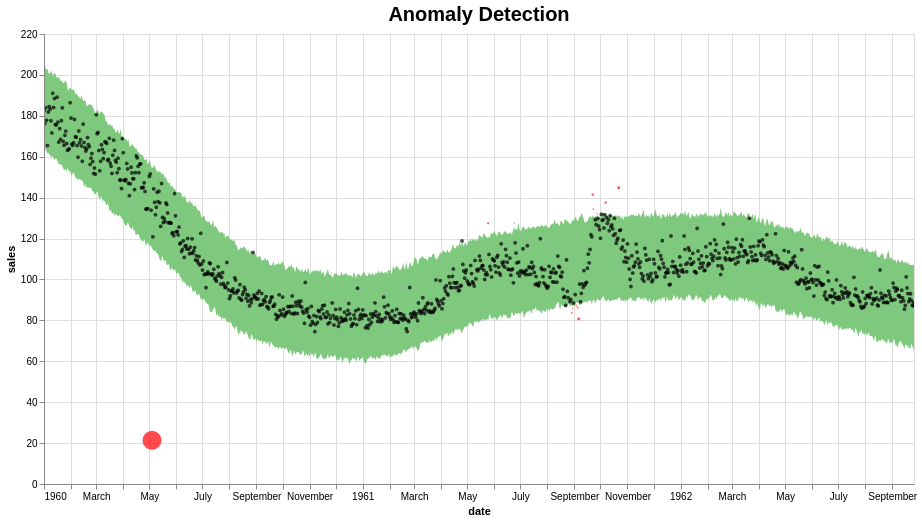

In [24]:
pred = fit_predict_model(df1)
pred = detect_anomalies(pred)
plot_anomalies(pred)

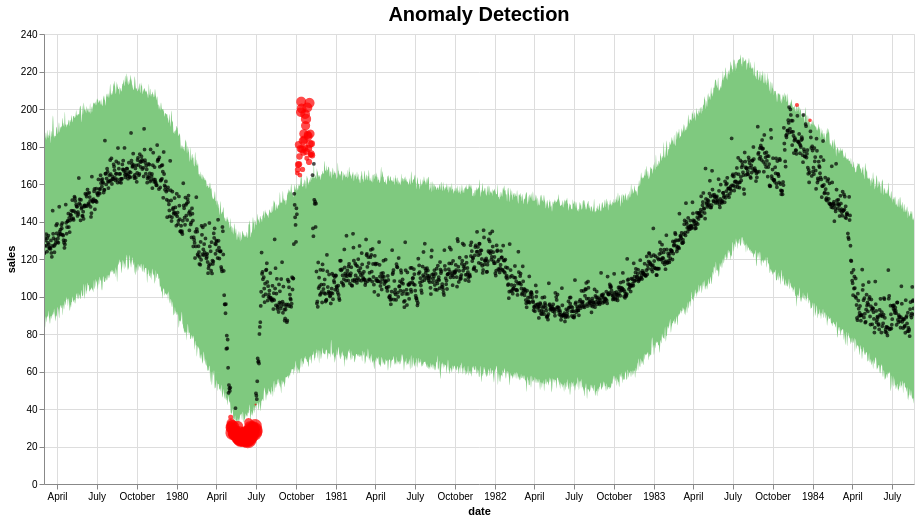

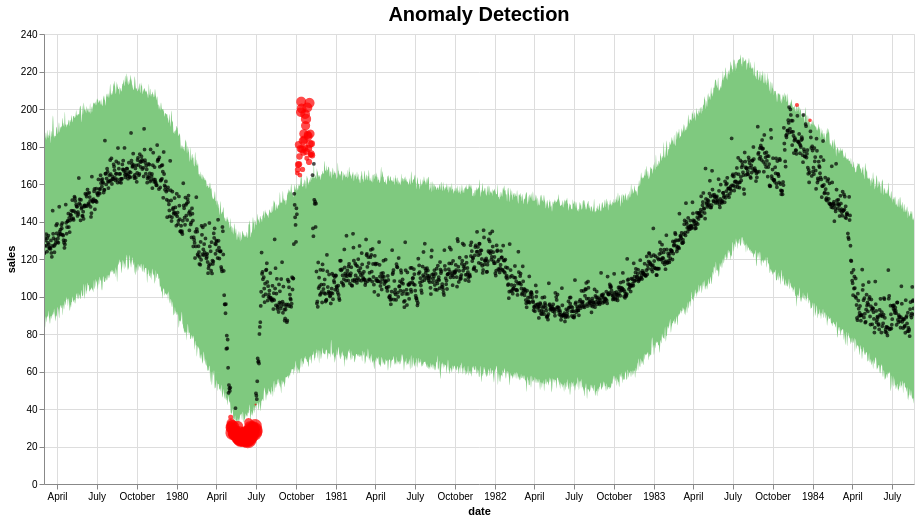

In [25]:
pred = fit_predict_model(df2)
pred = detect_anomalies(pred)
plot_anomalies(pred)

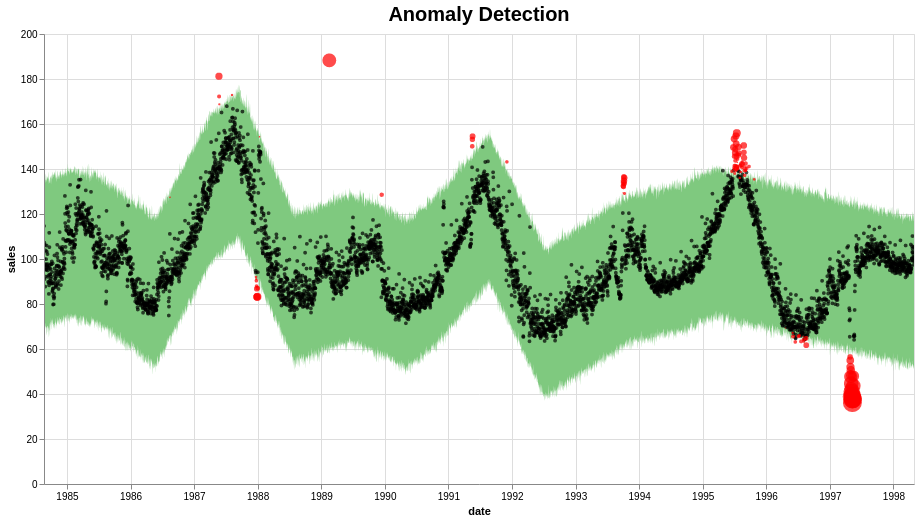

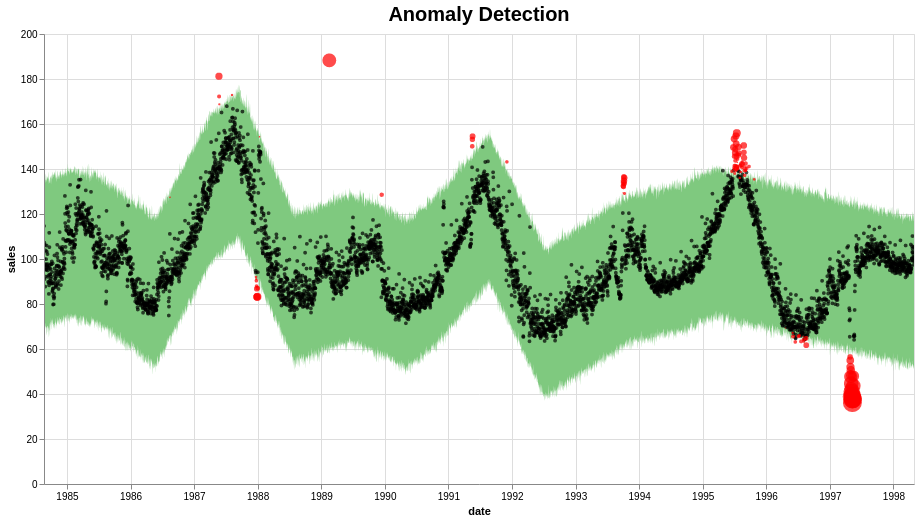

In [26]:
pred = fit_predict_model(df3)
pred = detect_anomalies(pred)
plot_anomalies(pred)